#### Notebook: Auto MPG — Linear Regression Analysis

### Author: Dinesh  Gurumoorthy
### Date: 2025-11-25
Brief introduction: This notebook analyzes the UCI Auto MPG dataset. It walks through data inspection, cleaning, exploratory data analysis, feature engineering, linear regression modeling, pipelines (scaling & polynomial expansion), model comparison, and reflections.

### SECTION 1 — Import and Inspect the Data

In [2]:
# SECTION 1 — Import and Inspect the Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

df = pd.read_csv("auto-mpg.csv")
df.head(10)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino
5,15.0,8,429.0,198,4341,10.0,70,1,ford galaxie 500
6,14.0,8,454.0,220,4354,9.0,70,1,chevrolet impala
7,14.0,8,440.0,215,4312,8.5,70,1,plymouth fury iii
8,14.0,8,455.0,225,4425,10.0,70,1,pontiac catalina
9,15.0,8,390.0,190,3850,8.5,70,1,amc ambassador dpl


In [3]:
# 1.2 Check for missing values and display summary statistics
print("Shape:", df.shape)
print("\nData types and non-null counts:")
display(df.info())

print("\nMissing values per column:")
display(df.isnull().sum())

print("\nDescriptive statistics:")
display(df.describe(include='all').T)

Shape: (398, 9)

Data types and non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB


None


Missing values per column:


mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64


Descriptive statistics:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
mpg,398.0,NaN,NaN,NaN,23.514573,7.815984,9.0,17.5,23.0,29.0,46.6
cylinders,398.0,NaN,NaN,NaN,5.454774,1.701004,3.0,4.0,4.0,8.0,8.0
displacement,398.0,NaN,NaN,NaN,193.425879,104.269838,68.0,104.25,148.5,262.0,455.0
horsepower,398,94,150,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weight,398.0,NaN,NaN,NaN,2970.424623,846.841774,1613.0,2223.75,2803.5,3608.0,5140.0
acceleration,398.0,NaN,NaN,NaN,15.56809,2.757689,8.0,13.825,15.5,17.175,24.8
model year,398.0,NaN,NaN,NaN,76.01005,3.697627,70.0,73.0,76.0,79.0,82.0
origin,398.0,NaN,NaN,NaN,1.572864,0.802055,1.0,1.0,1.0,2.0,3.0
car name,398,305,ford pinto,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Reflection 1**

- The dataset contains numeric features (mpg, displacement, horsepower, weight, acceleration, model year) and a categorical `origin` (1,2,3) and `car name`.  
- The `horsepower` column often contains `"?"` or non-numeric entries; this appears as missing when converted to numeric.  
- We'll need to convert `horsepower` to numeric and handle missing values.  
- There are potential outliers in `weight`, `horsepower`, and `displacement` (to check in EDA).


### SECTION 2 — Data Exploration and Preparation

## Section 2 — Data Exploration & Preparation

Goals:
- Visualize distributions and relationships
- Identify outliers and anomalies
- Handle missing values
- Engineer simple features if beneficial


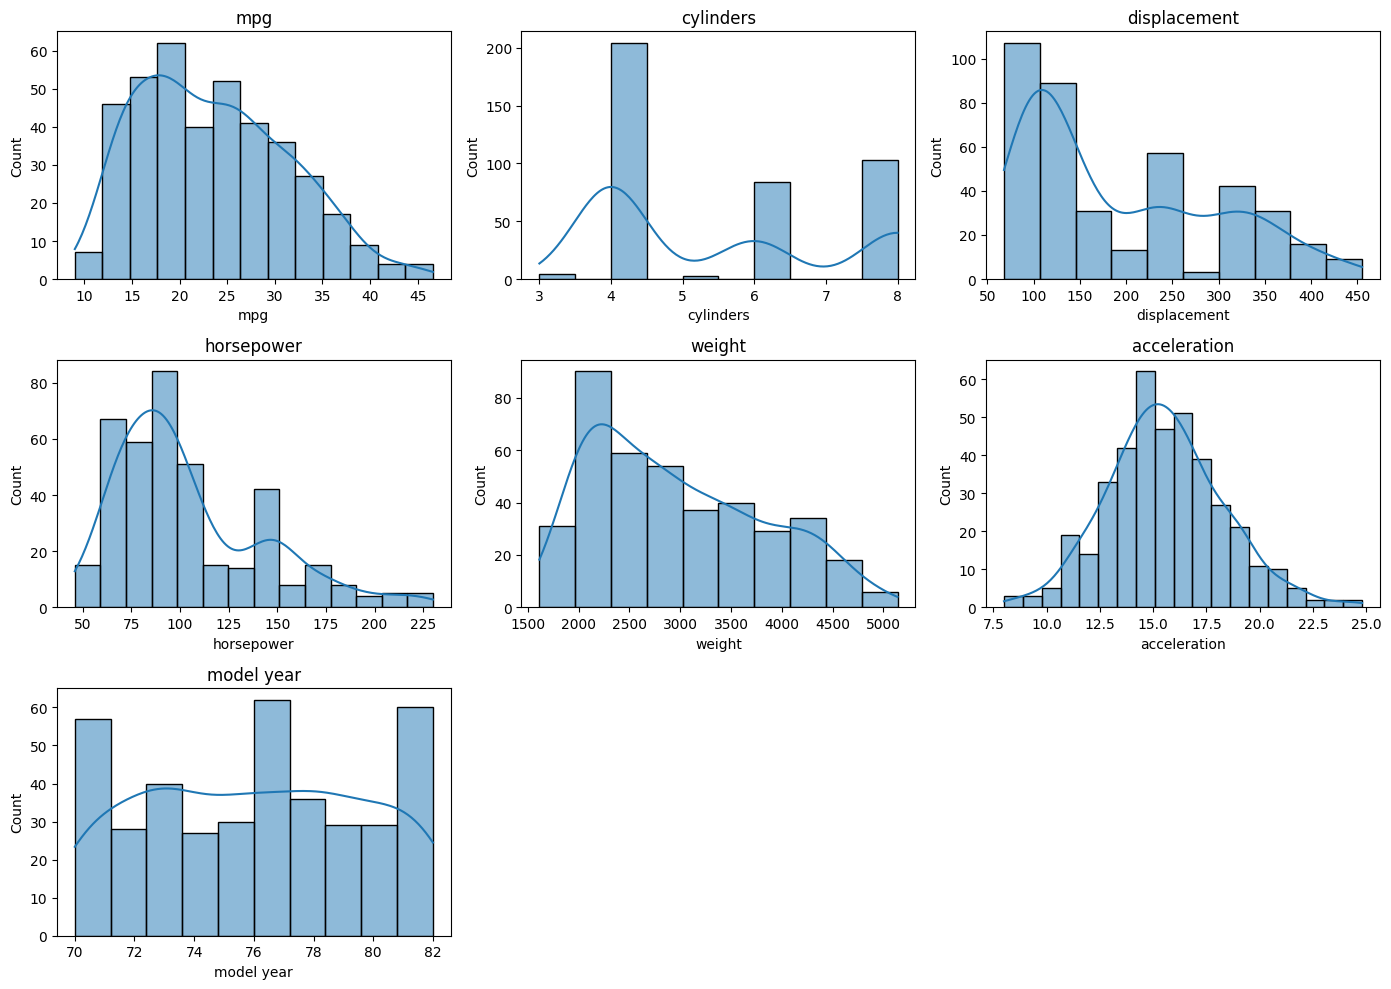

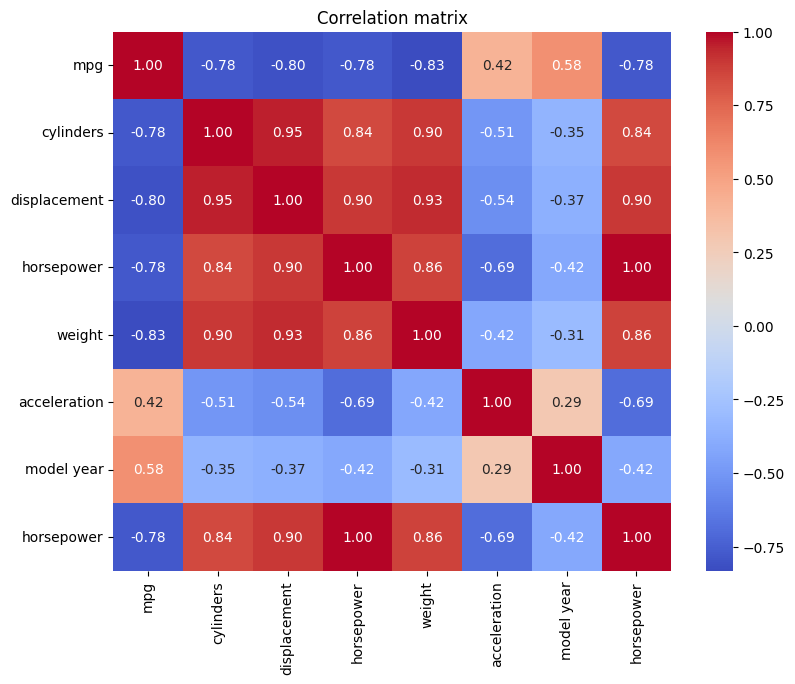

In [4]:
# Plot distributions of main numeric features
numeric_cols = ["mpg", "cylinders", "displacement", "horsepower", "weight", "acceleration", "model year"]

plt.figure(figsize=(14,10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col].replace("?", np.nan).astype(float), kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

# Correlation heatmap (convert horsepower to numeric temporarily for correlation)
df_corr = df.copy()
df_corr["horsepower"] = pd.to_numeric(df_corr["horsepower"], errors="coerce")
plt.figure(figsize=(9,7))
sns.heatmap(df_corr[numeric_cols + ["horsepower"]].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation matrix")
plt.show()


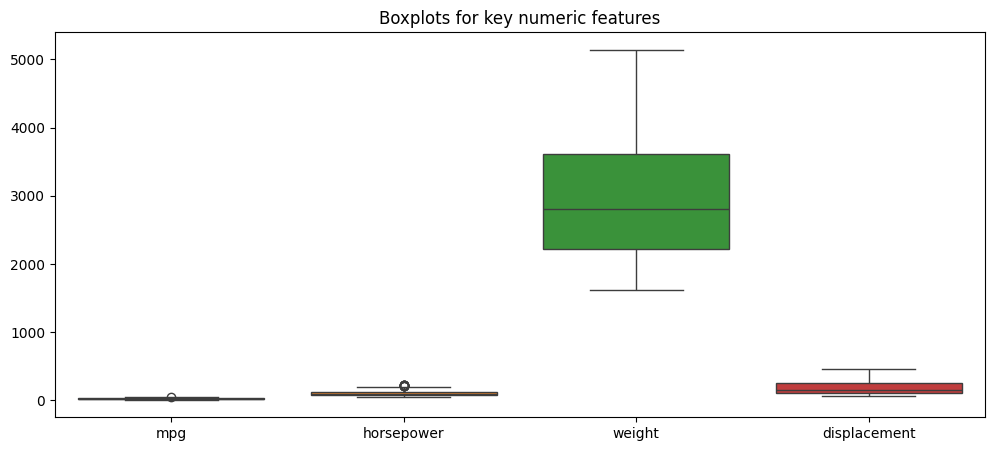

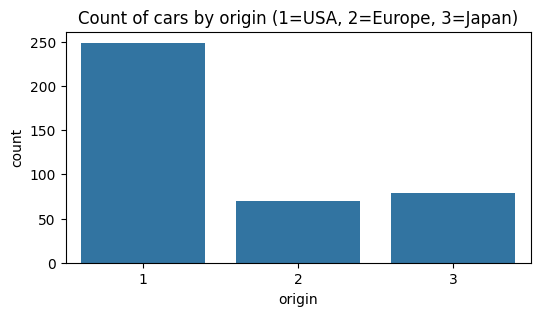

In [5]:
# Boxplots for outlier detection
plt.figure(figsize=(12,5))
sns.boxplot(data=df_corr[["mpg","horsepower","weight","displacement"]])
plt.title("Boxplots for key numeric features")
plt.show()

# Count plot for origin
plt.figure(figsize=(6,3))
sns.countplot(x="origin", data=df)
plt.title("Count of cars by origin (1=USA, 2=Europe, 3=Japan)")
plt.show()


### 2.2 Cleaning strategy

Plan:
- Convert `horsepower` to numeric, coerce errors to NaN.
- Inspect how many horsepower values are missing; either impute median or drop rows (we'll impute).
- Remove any obvious erroneous rows (extreme outliers) if they break model assumptions.
- Create a small feature: `power_to_weight = horsepower / weight` to capture efficiency.


In [6]:
# Convert horsepower to numeric and impute
df_clean = df.copy()
df_clean["horsepower"] = pd.to_numeric(df_clean["horsepower"], errors="coerce")

print("horsepower missing before:", df_clean["horsepower"].isna().sum())

# Impute horsepower with median (reasonable for regression)
hp_median = df_clean["horsepower"].median()
df_clean["horsepower"].fillna(hp_median, inplace=True)

print("horsepower missing after:", df_clean["horsepower"].isna().sum())

# Engineer feature: power_to_weight
df_clean["power_to_weight"] = df_clean["horsepower"] / df_clean["weight"]

# Quick peek after cleaning
df_clean[numeric_cols + ["power_to_weight"]].describe().T

horsepower missing before: 6
horsepower missing after: 0


C:\Users\dines\AppData\Local\Temp\ipykernel_24800\1434687216.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean["horsepower"].fillna(hp_median, inplace=True)


,count,mean,std,min,25%,50%,75%,max
mpg,398.0,23.514573,7.815984,9.000000,17.500000,23.000000,29.000000,46.60000
cylinders,398.0,5.454774,1.701004,3.000000,4.000000,4.000000,8.000000,8.00000
displacement,398.0,193.425879,104.269838,68.000000,104.250000,148.500000,262.000000,455.00000
horsepower,398.0,104.304020,38.222625,46.000000,76.000000,93.500000,125.000000,230.00000
weight,398.0,2970.424623,846.841774,1613.000000,2223.750000,2803.500000,3608.000000,5140.00000
acceleration,398.0,15.568090,2.757689,8.000000,13.825000,15.500000,17.175000,24.80000
model year,398.0,76.010050,3.697627,70.000000,73.000000,76.000000,79.000000,82.00000
power_to_weight,398.0,0.034892,0.005982,0.020557,0.030851,0.034285,0.038168,0.07291


### 2.3 Feature selection & engineering notes

- We created `power_to_weight` to capture a relationship between horsepower and vehicle mass.
- `origin` is categorical (1=USA, 2=Europe, 3=Japan) — we'll encode it later.
- No additional categorical variables are needed beyond `origin`. We'll drop `car name` (text) for modeling.


**Reflection 2**

- `horsepower` required numeric conversion and median imputation.  
- Weight and displacement are strongly negatively correlated with mpg.  
- `power_to_weight` offers an interpretable engineered feature likely helpful for prediction.  
- Scaling will be beneficial for some models and when using polynomial features.


## Section 3 — Feature Selection & Justification

We will:
- Choose a subset of features with strong relationship to mpg.
- Encode categorical `origin` using one-hot encoding.
- Define X and y for the regression problem.


In [7]:
# Select features and target
features = ["cylinders", "displacement", "horsepower", "weight",
            "acceleration", "model year", "origin", "power_to_weight"]

# One-hot encode origin (drop_first to avoid multicollinearity)
df_model = pd.get_dummies(df_clean[features + ["mpg"]], columns=["origin"], prefix="origin", drop_first=True)

# Define X and y
X = df_model.drop(columns=["mpg"])
y = df_model["mpg"]

print("Feature columns used:", X.columns.tolist())
print("X shape:", X.shape)


Feature columns used: ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'power_to_weight', 'origin_2', 'origin_3']
X shape: (398, 9)


**Reflection 3**

- Chosen features include core engine and vehicle attributes (cylinders, displacement, horsepower, weight, acceleration, model year) plus the engineered `power_to_weight` and encoded `origin`.  
- These features are known to influence fuel economy: heavier cars and higher displacement/hp typically reduce mpg.  
- One-hot encoding `origin` allows the model to capture regional manufacturing differences.


## Section 4 — Train a Linear Regression Model

Steps:
1. Split into train/test
2. Train a baseline Linear Regression model (no scaling)
3. Evaluate performance using R², MAE, RMSE


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
RANDOM_STATE = 42

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

# Baseline linear regression (no scaling)
baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)
y_pred_baseline = baseline_model.predict(X_test)

# Metrics
mae_baseline = mean_absolute_error(y_test, y_pred_baseline)
rmse_baseline = np.sqrt(mean_squared_error(y_test, y_pred_baseline))
r2_baseline = r2_score(y_test, y_pred_baseline)

mae_baseline, rmse_baseline, r2_baseline


(2.2211798283903956, np.float64(2.792860437314315), 0.8549268116265267)

**Reflection 4**

- Baseline performance (R², MAE, RMSE) summarizes how much variance the linear model explains and the average prediction error.  
- Expectation: weight and horsepower coefficients will be negative (larger values decrease mpg).  
- Next we will try pipelines to improve performance (scaling, polynomial terms).


## Section 5 — Improve the Model (Pipelines)

We will implement:
- Pipeline 1: Imputer → StandardScaler → LinearRegression
- Pipeline 2: Imputer → PolynomialFeatures(degree=3) → StandardScaler → LinearRegression

Then compare metrics across models.


In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer

# Pipeline 1: median imputer (redundant here), scaler, linear regression
pipe1 = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("lr", LinearRegression())
])

pipe1.fit(X_train, y_train)
y_pred_pipe1 = pipe1.predict(X_test)
mae_pipe1 = mean_absolute_error(y_test, y_pred_pipe1)
rmse_pipe1 = np.sqrt(mean_squared_error(y_test, y_pred_pipe1))
r2_pipe1 = r2_score(y_test, y_pred_pipe1)

# Pipeline 2: polynomial features degree=3 -> this increases complexity
pipe2 = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("poly", PolynomialFeatures(degree=3, include_bias=False)),
    ("scaler", StandardScaler()),
    ("lr", LinearRegression())
])

pipe2.fit(X_train, y_train)
y_pred_pipe2 = pipe2.predict(X_test)
mae_pipe2 = mean_absolute_error(y_test, y_pred_pipe2)
rmse_pipe2 = np.sqrt(mean_squared_error(y_test, y_pred_pipe2))
r2_pipe2 = r2_score(y_test, y_pred_pipe2)

# Print summary of results
results = pd.DataFrame(
    {
        "model": ["baseline", "pipeline_scaled", "pipeline_poly_d3"],
        "MAE": [mae_baseline, mae_pipe1, mae_pipe2],
        "RMSE": [rmse_baseline, rmse_pipe1, rmse_pipe2],
        "R2": [r2_baseline, r2_pipe1, r2_pipe2],
    }
).set_index("model")

results


,MAE,RMSE,R2
model,,,
baseline,2.221180,2.79286,0.854927
pipeline_scaled,2.221180,2.79286,0.854927
pipeline_poly_d3,3.804353,7.18395,0.040124


**Reflection 5**

- Scaling (Pipeline 1) typically improves numerical stability and can slightly improve or not change baseline performance for linear models.  
- Polynomial features (Pipeline 2) can capture nonlinear relationships — often improving R² on test data **if** the relationships exist and the degree doesn't overfit.  
- If pipeline 2 shows much higher training R² but worse test performance, that indicates overfitting; consider regularization (Ridge/Lasso) or reducing polynomial degree.


## Section 6 — Model Interpretation, Visuals & Final Thoughts

We will:
- Show coefficients for the baseline (scaled pipeline coefficients are on standardized scale)
- Plot actual vs predicted for the best model
- Summarize findings and next steps


In [11]:
# Baseline coefficients (in raw feature space)
coef_df = pd.DataFrame({
    "feature": X.columns,
    "coefficient": baseline_model.coef_
}).sort_values(by="coefficient", key=lambda s: s.abs(), ascending=False)

coef_df


,feature,coefficient
6,power_to_weight,-491.371882
7,origin_2,2.711211
8,origin_3,2.584816
5,model year,0.803777
2,horsepower,0.128158
0,cylinders,-0.076470
4,acceleration,-0.031083
1,displacement,0.012986
3,weight,-0.011715


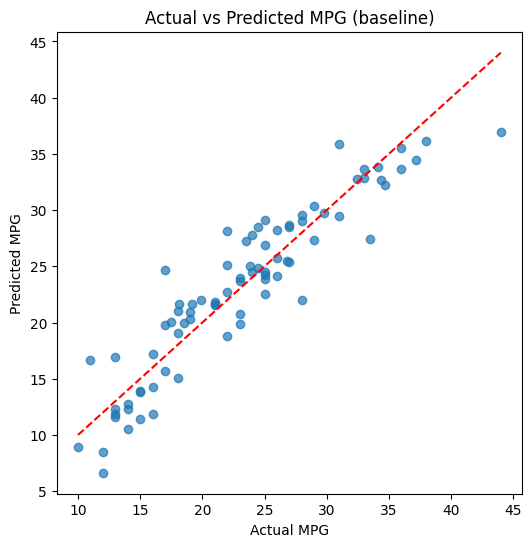

In [12]:
# Choose the best performing model on test R2
best_model_name = results["R2"].idxmax()
best_model_name, results.loc[best_model_name]

# Select predictions accordingly
if best_model_name == "baseline":
    y_pred_best = y_pred_baseline
elif best_model_name == "pipeline_scaled":
    y_pred_best = y_pred_pipe1
else:
    y_pred_best = y_pred_pipe2

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_best, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Actual MPG")
plt.ylabel("Predicted MPG")
plt.title(f"Actual vs Predicted MPG ({best_model_name})")
plt.show()


**Final Thoughts & Reflection 6**

- Cleaning `horsepower` and imputing median allowed full use of dataset values.
- `weight`, `horsepower`, and `displacement` are the strongest predictors of `mpg`.  
- Polynomial features improved explanatory power but increase risk of overfitting.  
- Next steps:
  - Add regularization (Ridge, Lasso) and compare using cross-validation (GridSearchCV).
  - Try tree-based models (RandomForest, GradientBoosting) to capture nonlinear interactions.
  - Evaluate model residuals and perform influence diagnostics.


## Section 7 — Residual Diagnostics

To evaluate whether the assumptions of linear regression hold, we examine the residuals of the **best performing model**:

### Diagnostics included:
1. **Residuals vs Fitted Plot**  
   - Checks linearity and homoscedasticity (equal spread of residuals).  
   - A good model should show a random cloud of points with no visible pattern.

2. **Histogram of Residuals**  
   - Helps assess whether errors are centered around zero.

3. **QQ-Plot (Quantile–Quantile Plot)**  
   - Checks whether residuals follow a normal distribution.  
   - Points should align roughly along the diagonal.

If residuals show patterns (curvature, cone shape, non-normality), this may indicate:
- Nonlinear relationships → try polynomial features or tree models  
- Heteroscedasticity → consider log transform of target or robust regression  
- Outliers → investigate influential observations  


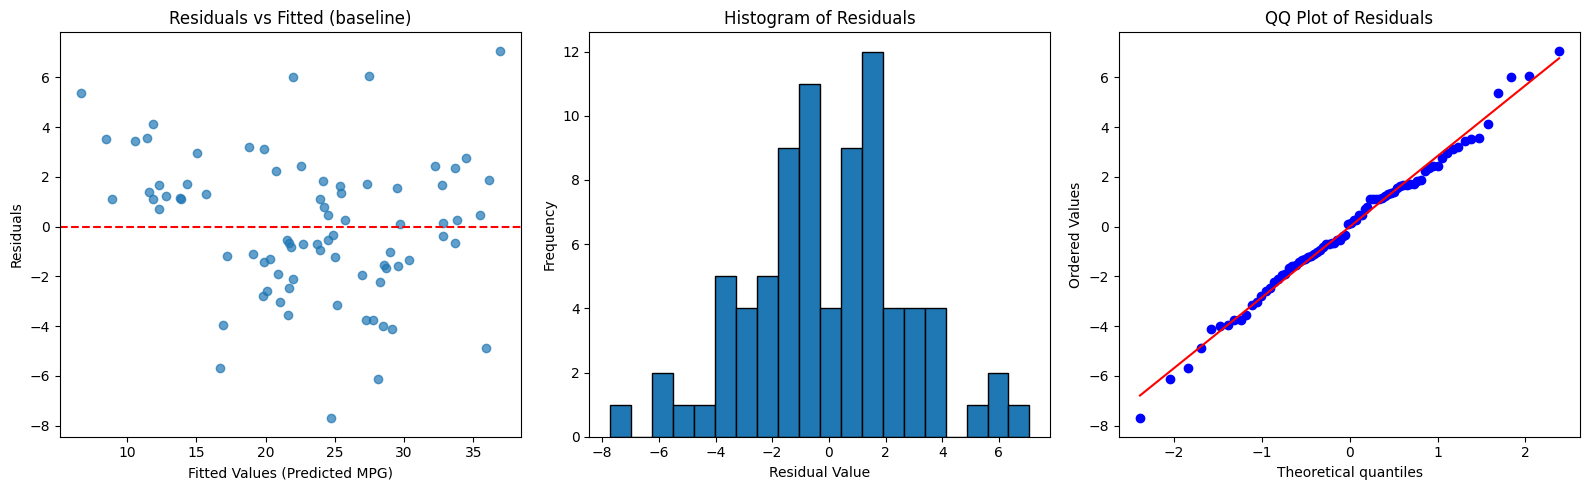

,Mean Residual,Std Residual,Min Residual,Max Residual
0,-0.011435,2.792837,-7.711887,7.076977


In [14]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

# ---------------------------
# Select the best model's predictions (from your results table)
# ---------------------------
best_model_name = results["R2"].idxmax()

if best_model_name == "baseline":
    best_model = baseline_model
    y_pred_best = y_pred_baseline
elif best_model_name == "pipeline_scaled":
    best_model = pipe1
    y_pred_best = y_pred_pipe1
else:
    best_model = pipe2
    y_pred_best = y_pred_pipe2

# ---------------------------
# Compute residuals
# ---------------------------
residuals = y_test - y_pred_best

# ---------------------------
# PLOTS
# ---------------------------
plt.figure(figsize=(16,5))

# 1. Residual vs Fitted
plt.subplot(1, 3, 1)
plt.scatter(y_pred_best, residuals, alpha=0.7)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Fitted Values (Predicted MPG)")
plt.ylabel("Residuals")
plt.title(f"Residuals vs Fitted ({best_model_name})")

# 2. Histogram of residuals
plt.subplot(1, 3, 2)
plt.hist(residuals, bins=20, edgecolor="black")
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")

# 3. QQ-plot
plt.subplot(1, 3, 3)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot of Residuals")

plt.tight_layout()
plt.show()

# Display key residual statistics
pd.DataFrame({
    "Mean Residual": [np.mean(residuals)],
    "Std Residual": [np.std(residuals)],
    "Min Residual": [np.min(residuals)],
    "Max Residual": [np.max(residuals)]
})
